In [234]:
# to handle datasets
import pandas as pd
import numpy as np

# for text / string processing
import re

# for plotting
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# for tree binarisation
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score


# to build the models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# to evaluate the models
from sklearn.metrics import roc_auc_score
from sklearn import metrics

pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [235]:
data = pd.read_csv('train.csv')
data_val = pd.read_csv('test.csv')
print(data.shape)
data.head()
submission = pd.read_csv('sample_submission.csv')
submission.head()

(614, 13)


,Loan_ID,Loan_Status


In [236]:
data.dtypes
data_val.dtypes


Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome      int64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
dtype: object

In [237]:
#Create a new column as Total Income

data['TotalIncome']= data['ApplicantIncome']+data['CoapplicantIncome']
data_val['TotalIncome']=data_val['ApplicantIncome']+data_val['CoapplicantIncome']
#Take a log of TotalIncome + 1, adding 1 to deal with zeros of TotalIncome it it exists
data['Log_TotalIncome']=np.log(data['TotalIncome'])
data_val['Log_TotalIncome']=np.log(data_val['TotalIncome'])

In [238]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,Log_TotalIncome
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,5849.0,8.674026
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0,8.714568
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0,8.006368
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,8.505323
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0,8.699515


In [239]:
print('Number of Loan Id labels: ', len(data.Loan_ID.unique()))
print('Number of Loan in the Dataset: ', len(data))

for df in data, data_val:
    df['Dependents'] = np.where(df['Dependents'] == '3+','3',df['Dependents'])
    df['Dependents'] = pd.to_numeric(df['Dependents'])
    
data.Dependents.fillna(data.Dependents.mode()[0], inplace=True)
data_val.Dependents.fillna(data_val.Dependents.mode()[0], inplace=True)

Number of Loan Id labels:  614
Number of Loan in the Dataset:  614


In [240]:
for df in data, data_val:
    data.Property_Area.value_counts().sort_values(ascending=False)
    location = [x for x in df.Property_Area.value_counts().sort_values(ascending=False).head(10).index]
    for label in location:
        df[label] = np.where(df['Property_Area']==label, 1, 0)

In [241]:
del data['Property_Area']
del data_val['Property_Area']

Id is a unique identifier for each of the houses. Thus this is not a variable that we can use.

In [242]:
# find categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 6 categorical variables


In [243]:
# find numerical variables
numerical = [var for var in data.columns if data[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 11 numerical variables


## Find discrete variables
To identify discrete variables, I will select from all the numerical ones, those that contain a finite and small number of distinct values. See below.

In [244]:
# let's visualise the values of the discrete variables
discrete = []
for var in numerical:
    if len(data[var].unique())<20:
        print(var, ' values: ', data[var].unique())
        discrete.append(var)
        
print('There are {} discrete variables'.format(len(discrete)))

Dependents  values:  [0. 1. 2. 3.]
Loan_Amount_Term  values:  [360. 120. 240.  nan 180.  60. 300. 480.  36.  84.  12.]
Credit_History  values:  [ 1.  0. nan]
Semiurban  values:  [0 1]
Urban  values:  [1 0]
Rural  values:  [0 1]
There are 6 discrete variables


## Types of problems within the variables (section 3)

In [245]:
for var in data.columns:
    if data[var].isnull().sum() > 0:
        print(var, data[var].isnull().mean())

Gender 0.021172638436482084
Married 0.004885993485342019
Self_Employed 0.05211726384364821
LoanAmount 0.035830618892508145
Loan_Amount_Term 0.02280130293159609
Credit_History 0.08143322475570032


In [246]:
# let's inspect the type of those variables with a lot of missing information
for var in data.columns:
    if data[var].isnull().mean() > 0.80:
        print(var, data[var].unique())

There is no variables with a lot of missing information. 

## Outliers

In [247]:
continuous = [ var for var in numerical if var not in discrete and var not in ['Loan_Id', 'Loan_Status']]
continuous

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'TotalIncome',
 'Log_TotalIncome']

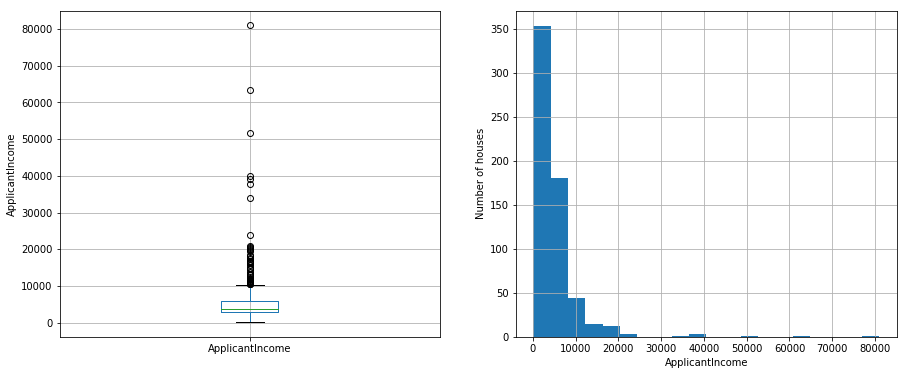

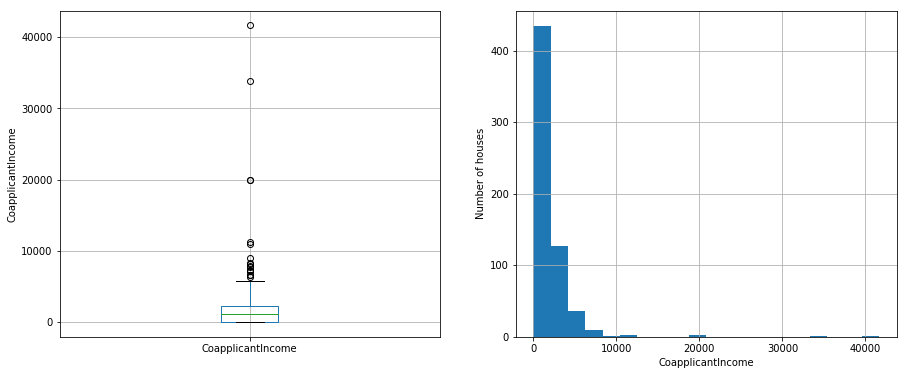

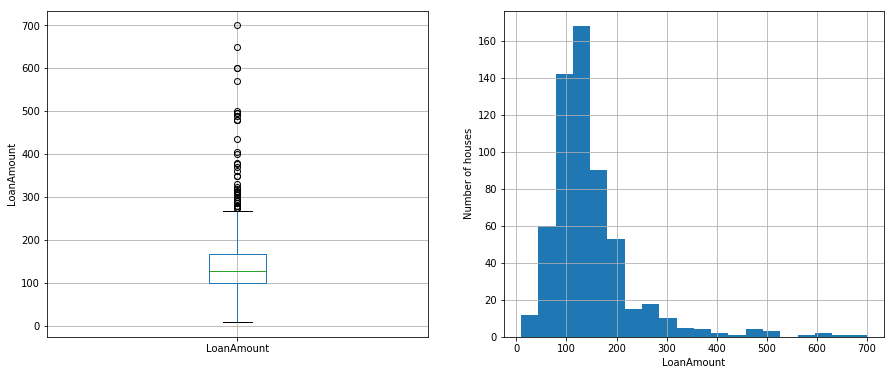

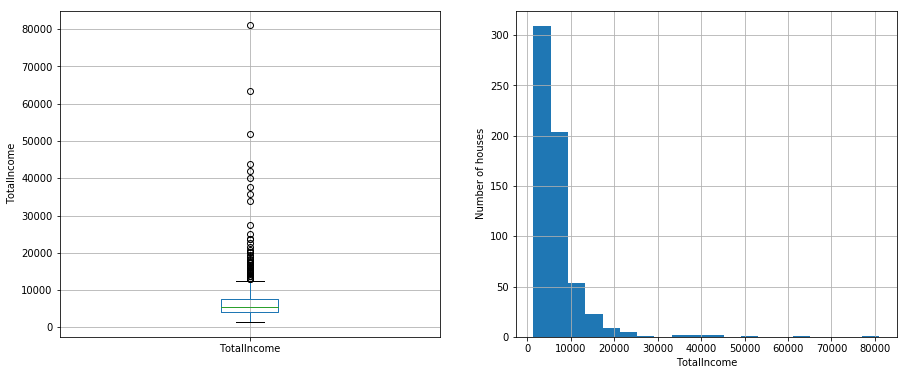

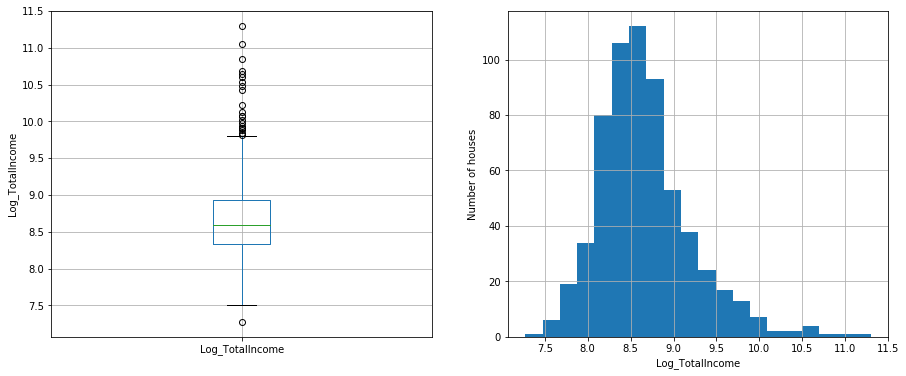

In [248]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in continuous:
    plt.figure(figsize = (15,6))
    plt.subplot(1, 2, 1)
    fig = data.boxplot(column = var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = data[var].hist(bins = 20)
    fig.set_ylabel('Number of houses')
    fig.set_xlabel(var)
    
    plt.show()

. In addition, the majority of the variables are not normally distributed. To tackle the 2 aspects together, I will do discretisation. And in particular, I will use trees to find the right buckets onto which I will divide the variables.

## Outliers in discrete variables

In [249]:
for var in discrete:
    print( data[var].value_counts() / np.float(len(data)))
    print()

0.0    0.586319
1.0    0.166124
2.0    0.164495
3.0    0.083062
Name: Dependents, dtype: float64

360.0    0.833876
180.0    0.071661
480.0    0.024430
300.0    0.021173
84.0     0.006515
240.0    0.006515
120.0    0.004886
36.0     0.003257
60.0     0.003257
12.0     0.001629
Name: Loan_Amount_Term, dtype: float64

1.0    0.773616
0.0    0.144951
Name: Credit_History, dtype: float64

0    0.620521
1    0.379479
Name: Semiurban, dtype: float64

0    0.67101
1    0.32899
Name: Urban, dtype: float64

0    0.708469
1    0.291531
Name: Rural, dtype: float64



Most of the discrete variables show values that are shared by a tiny proportion of houses in the dataset. For linear regression, this may not be a problem, but it most likely will be for tree methods.

### Number of labels: cardinality

In [250]:
for var in categorical:
    print(var, ' contains ',len(data[var].unique()), ' labels')

Loan_ID  contains  614  labels
Gender  contains  3  labels
Married  contains  3  labels
Education  contains  2  labels
Self_Employed  contains  3  labels
Loan_Status  contains  2  labels


Most of the variables, contain only a few labels. Then, we do not have to deal with high cardinality. That is good news!

### Separate train and test set

In [251]:
#Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data, data.Loan_Status, test_size=0.2,
                                                    random_state=0)
X_train.shape, X_test.shape



((491, 17), (123, 17))

### Engineering missing values in numerical variables (section 5)

##### Continuous variables

In [252]:
# print variables with missing data
for col in continuous:
    if X_train[col].isnull().mean() > 0:
        print(col, X_train[col].isnull().mean())

LoanAmount 0.04073319755600815


LoanAmount : create additional variable with NA + median imputation

In [253]:
for df in [X_train, X_test,data_val,data]:
    for var in ['LoanAmount']:
        df[var+'_NA'] = np.where(df[var].isnull(),1,0)
        df[var].fillna(X_train[var].median(), inplace = True)
        

##### Discrete variables

In [254]:
for col in discrete:
    if X_train[col].isnull().mean() > 0:
        print(col, X_train[col].isnull().mean())

Loan_Amount_Term 0.02240325865580448
Credit_History 0.0835030549898167


In [255]:
for df in [X_train, X_test,data_val,data]:
    for var in ['Loan_Amount_Term']:
        df[var+'_NA'] = np.where(df[var].isnull(),1,0)
        df[var].fillna(X_train[var].median(), inplace = True)

Credit_History will be imputed by most frequent category, because NA is low

In [256]:
objects = ['Credit_History','Gender','Self_Employed','Married']

for df in [X_train, X_test,data_val,data]:
    for var in objects:
        df[var].fillna(X_train[var].mode()[0], inplace=True)
       

In [257]:
data_val.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,TotalIncome,Log_TotalIncome,Urban,Semiurban,Rural,LoanAmount_NA,Loan_Amount_Term_NA
0,LP001015,Male,Yes,0.0,Graduate,No,5720,0,110.0,360.0,1.0,5720,8.651724,1,0,0,0,0
1,LP001022,Male,Yes,1.0,Graduate,No,3076,1500,126.0,360.0,1.0,4576,8.428581,1,0,0,0,0
2,LP001031,Male,Yes,2.0,Graduate,No,5000,1800,208.0,360.0,1.0,6800,8.824678,1,0,0,0,0
3,LP001035,Male,Yes,2.0,Graduate,No,2340,2546,100.0,360.0,1.0,4886,8.494129,1,0,0,0,0
4,LP001051,Male,No,0.0,Not Graduate,No,3276,0,78.0,360.0,1.0,3276,8.094378,1,0,0,0,0


## Outliers in Numerical variables

In [258]:

IQR = data.ApplicantIncome.quantile(0.75) - data.ApplicantIncome.quantile(0.25)

Lower_fence = data.ApplicantIncome.quantile(0.25) - (IQR * 1.5)
Upper_fence = data.ApplicantIncome.quantile(0.75) + (IQR * 1.5)

Upper_fence, Lower_fence, IQR

(10171.25, -1498.75, 2917.5)

In [259]:
# And if we are looking at really extreme values
# using the interquantile proximity rule

IQR = data.ApplicantIncome.quantile(0.75) - data.ApplicantIncome.quantile(0.25)

Lower_fence = data.ApplicantIncome.quantile(0.25) - (IQR * 3)
Upper_fence = data.ApplicantIncome.quantile(0.75) + (IQR * 3)

Upper_fence, Lower_fence, IQR

(14547.5, -5875.0, 2917.5)

In [260]:
# lets look at the actual amount of applicant income on the upper Fare ranges

print('total applicants: {}'.format(data.shape[0]))

print('applicant income higher than 10171: {}'.format(
    data[data.ApplicantIncome > 10171].shape[0]))

print('applicant income higher than 14547: {}'.format(
    data[data.ApplicantIncome > 14547].shape[0]))

total applicants: 614
applicant income higher than 10171: 50
applicant income higher than 14547: 32


In [261]:
total_applicants = np.float(data.shape[0])

print('% applicant income higher than 10171: {}'.format(
    data[data.ApplicantIncome > 10171].shape[0] / total_applicants))

print('% applicant income higher than 14547: {}'.format(
    data[data.ApplicantIncome > 14547].shape[0] / total_applicants))

% applicant income higher than 10171: 0.08143322475570032
% applicant income higher than 14547: 0.05211726384364821


When using the 1.5 times interquantile range itnerval to find outliers, we find that 6% of the applicants have extremely high income. We can go ahead and investigate the nature of this outliers.

In [262]:
data.CoapplicantIncome.describe()

count      614.000000
mean      1621.245798
std       2926.248369
min          0.000000
25%          0.000000
50%       1188.500000
75%       2297.250000
max      41667.000000
Name: CoapplicantIncome, dtype: float64

In [263]:
Upper_boundary = data.CoapplicantIncome.mean() + 1.5* data.CoapplicantIncome.std()
Lower_boundary = data.CoapplicantIncome.mean() - 1.5* data.CoapplicantIncome.std()

Upper_boundary, Lower_boundary

(6010.618351863384, -2768.126755809182)

THe upper boundary is 6010 while the max value is 41667


In [264]:
# let's find out whether there are outliers according to the above boundaries:

# let's remove first the passengers with missing data for Age
data = data.dropna(subset=['CoapplicantIncome'])

total_applicants = np.float(data.shape[0])

print('coapplicant income higher than than 6010 (Gaussian approach): {}'.format(
    data[data.CoapplicantIncome > 6010].shape[0] / total_applicants))

print('coapplicant income higher than than 40000 (IQR): {}'.format(
    data[data.CoapplicantIncome > 40000].shape[0] / total_applicants))



coapplicant income higher than than 6010 (Gaussian approach): 0.029315960912052116
coapplicant income higher than than 40000 (IQR): 0.0016286644951140066


1 coappliant extremely rich, and around 20 has high income

In [265]:
data[data.CoapplicantIncome>6010]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,Log_TotalIncome,Semiurban,Urban,Rural,LoanAmount_NA,Loan_Amount_Term_NA
9,LP001020,Male,Yes,1.0,Graduate,No,12841,10968.0,349.0,360.0,1.0,N,23809.0,10.077819,1,0,0,0,0
12,LP001028,Male,Yes,2.0,Graduate,No,3073,8106.0,200.0,360.0,1.0,Y,11179.0,9.321792,0,1,0,0,0
38,LP001114,Male,No,0.0,Graduate,No,4166,7210.0,184.0,360.0,1.0,Y,11376.0,9.339261,0,1,0,0,0
122,LP001431,Female,No,0.0,Graduate,No,2137,8980.0,137.0,360.0,0.0,Y,11117.0,9.316231,1,0,0,0,0
135,LP001488,Male,Yes,3.0,Graduate,No,4000,7750.0,290.0,360.0,1.0,N,11750.0,9.371609,1,0,0,0,0
177,LP001610,Male,Yes,3.0,Graduate,No,5516,11300.0,495.0,360.0,0.0,N,16816.0,9.730086,1,0,0,0,0
180,LP001633,Male,Yes,1.0,Graduate,No,6400,7250.0,180.0,360.0,0.0,N,13650.0,9.521495,0,1,0,0,0
253,LP001843,Male,Yes,1.0,Not Graduate,No,2661,7101.0,279.0,180.0,1.0,Y,9762.0,9.186253,1,0,0,0,0
349,LP002138,Male,Yes,0.0,Graduate,No,2625,6250.0,187.0,360.0,1.0,Y,8875.0,9.090994,0,0,1,0,0
372,LP002201,Male,Yes,2.0,Graduate,Yes,9323,7873.0,380.0,300.0,1.0,Y,17196.0,9.752432,0,0,1,0,0


In [266]:

IQR = data.LoanAmount.quantile(0.75) - data.LoanAmount.quantile(0.25)

Lower_fence = data.LoanAmount.quantile(0.25) - (IQR * 1.5)
Upper_fence = data.LoanAmount.quantile(0.75) + (IQR * 1.5)

Upper_fence, Lower_fence, IQR

(261.5, 3.5, 64.5)

In [267]:

IQR = data.LoanAmount.quantile(0.75) - data.LoanAmount.quantile(0.25)

Lower_fence = data.LoanAmount.quantile(0.25) - (IQR * 3)
Upper_fence = data.LoanAmount.quantile(0.75) + (IQR * 3)

Upper_fence, Lower_fence, IQR

(358.25, -93.25, 64.5)

In [268]:
total_applicants = np.float(data.shape[0])

print('loan higher than than 270 (Gaussian approach): {}'.format(
    data[data.LoanAmount > 270].shape[0] / total_applicants))

print('loan higher than than 372 (IQR): {}'.format(
    data[data.LoanAmount > 372].shape[0] / total_applicants))

loan higher than than 270 (Gaussian approach): 0.06351791530944625
loan higher than than 372 (IQR): 0.02768729641693811


In [269]:
data['TotalIncome']= data['ApplicantIncome']+data['CoapplicantIncome']
data_val['TotalIncome']=data_val['ApplicantIncome']+data_val['CoapplicantIncome']
#Take a log of TotalIncome + 1, adding 1 to deal with zeros of TotalIncome it it exists
data['Log_TotalIncome']=np.log(data['TotalIncome'])
data_val['Log_TotalIncome']=np.log(data_val['TotalIncome'])

In [270]:
def top_code(df, variable, top):
    return np.where(df[variable]>top, top, df[variable])

for df in [X_train, X_test, data_val,data]:
    df['ApplicantIncome'] = top_code(df, 'ApplicantIncome', 14547)
    df['CoapplicantIncome'] = top_code(df, 'CoapplicantIncome', 6010)
    df['LoanAmount'] = top_code(df, 'LoanAmount', 270)


In [271]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,Log_TotalIncome,Semiurban,Urban,Rural,LoanAmount_NA,Loan_Amount_Term_NA
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,128.0,360.0,1.0,Y,5849.0,8.674026,0,1,0,1,0
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,N,6091.0,8.714568,0,0,1,0,0
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Y,3000.0,8.006368,0,1,0,0,0
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Y,4941.0,8.505323,0,1,0,0,0
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Y,6000.0,8.699515,0,1,0,0,0


In [272]:
# Let's check if that worked
for var in ['ApplicantIncome','CoapplicantIncome','LoanAmount']:
    print(var,' max value: ',X_train[var].max())

ApplicantIncome  max value:  14547
CoapplicantIncome  max value:  6010.0
LoanAmount  max value:  270.0


### Engineering rare labels in categorical variables (section 9)

In [274]:
# find unfrequent labels in categorical variables
for var in categorical:
    print(var, X_train[var].value_counts()/np.float(len(X_train)))
    print()

Loan_ID LP001917    0.002037
LP001924    0.002037
LP001514    0.002037
LP001492    0.002037
LP002868    0.002037
LP001439    0.002037
LP001647    0.002037
LP002684    0.002037
LP001357    0.002037
LP002068    0.002037
LP001964    0.002037
LP001940    0.002037
LP002110    0.002037
LP002223    0.002037
LP001572    0.002037
LP002714    0.002037
LP002842    0.002037
LP001935    0.002037
LP002106    0.002037
LP002874    0.002037
LP001369    0.002037
LP002530    0.002037
LP002398    0.002037
LP002190    0.002037
LP001751    0.002037
LP001047    0.002037
LP002501    0.002037
LP001640    0.002037
LP002515    0.002037
LP001349    0.002037
              ...   
LP002493    0.002037
LP001656    0.002037
LP002446    0.002037
LP002435    0.002037
LP001884    0.002037
LP001531    0.002037
LP001560    0.002037
LP001915    0.002037
LP002401    0.002037
LP002716    0.002037
LP002473    0.002037
LP001859    0.002037
LP001518    0.002037
LP001497    0.002037
LP001370    0.002037
LP001050    0.002037
LP001

No rare label found

### Encode categorical variables (section 10)

In [275]:
categorical

['Loan_ID', 'Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Status']

Married, Education, self_employed, Gender: One hot encoding

Property_Area: replace by risk probability

In [276]:
for df in [X_train,X_test,data,data_val]:
    for var in ['Gender','Married','Education','Self_Employed']:
        df[var] = pd.get_dummies(df[var], drop_first = True)
        
for df in [X_train,data]:
    for var in ['Loan_Status']:
        df[var] = pd.get_dummies(df[var], drop_first = True)

In [277]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,Log_TotalIncome,Semiurban,Urban,Rural,LoanAmount_NA,Loan_Amount_Term_NA
0,LP001002,1,0,0.0,0,0,5849,0.0,128.0,360.0,1.0,1,5849.0,8.674026,0,1,0,1,0
1,LP001003,1,1,1.0,0,0,4583,1508.0,128.0,360.0,1.0,0,6091.0,8.714568,0,0,1,0,0
2,LP001005,1,1,0.0,0,1,3000,0.0,66.0,360.0,1.0,1,3000.0,8.006368,0,1,0,0,0
3,LP001006,1,1,0.0,1,0,2583,2358.0,120.0,360.0,1.0,1,4941.0,8.505323,0,1,0,0,0
4,LP001008,1,0,0.0,0,0,6000,0.0,141.0,360.0,1.0,1,6000.0,8.699515,0,1,0,0,0


In [278]:
variables_that_need_scaling = ['ApplicantIncome', 'CoapplicantIncome', 'Loan_Amount_Term', 'LoanAmount', 'Dependents']

In [279]:
training_vars = [var for var in X_train.columns if var not in ['Loan_ID', 'Loan_Status']]
training_vars

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'TotalIncome',
 'Log_TotalIncome',
 'Semiurban',
 'Urban',
 'Rural',
 'LoanAmount_NA',
 'Loan_Amount_Term_NA']

In [280]:
X_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome,Log_TotalIncome,Semiurban,Urban,Rural,LoanAmount_NA,Loan_Amount_Term_NA
90,LP001316,1,1,0.0,0,0,2958,2900.0,131.0,360.0,1.0,1,5858.0,8.675564,1,0,0,0,0
533,LP002729,1,0,1.0,0,0,11250,0.0,196.0,360.0,1.0,0,11250.0,9.328123,1,0,0,0,0
452,LP002448,1,1,0.0,0,0,3948,1733.0,149.0,360.0,0.0,0,5681.0,8.644883,0,0,1,0,0
355,LP002144,0,0,0.0,0,0,3813,0.0,116.0,180.0,1.0,1,3813.0,8.246172,0,1,0,0,0
266,LP001877,1,1,2.0,0,0,4708,1387.0,150.0,360.0,1.0,1,6095.0,8.715224,1,0,0,0,0


In [281]:
scaler = MinMaxScaler() # create an instance
scaler.fit(X_train[training_vars]) #  fit  the scaler to the train set and then transform it

MinMaxScaler(copy=True, feature_range=(0, 1))

### Machine Learning algorithm building

In [282]:
xgb_model = xgb.XGBClassifier()

eval_set = [(X_test[training_vars], y_test)]
xgb_model.fit(X_train[training_vars], y_train, eval_metric="auc", eval_set=eval_set, verbose=False)

pred = xgb_model.predict_proba(X_train[training_vars])
print('xgb train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
pred = xgb_model.predict_proba(X_test[training_vars])
print('xgb test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

xgb train roc-auc: 0.9634954913995605
xgb test roc-auc: 0.7781144781144781


In [283]:
y_train.head()


90     Y
533    N
452    N
355    Y
266    Y
Name: Loan_Status, dtype: object

In [284]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train[training_vars], y_train)

pred = rf_model.predict_proba(X_train[training_vars])
print('RF train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
pred = rf_model.predict_proba(X_test[training_vars])
print('RF test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

RF train roc-auc: 0.9995548230658483
RF test roc-auc: 0.7757575757575758


In [285]:
ada_model = AdaBoostClassifier()
ada_model.fit(X_train[training_vars], y_train)

pred = ada_model.predict_proba(X_train[training_vars])
print('Adaboost train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
pred = ada_model.predict_proba(X_test[training_vars])
print('Adaboost test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Adaboost train roc-auc: 0.8980165946806092
Adaboost test roc-auc: 0.7968013468013468


In [286]:
logit_model = LogisticRegression()
logit_model.fit(scaler.transform(X_train[training_vars]), y_train)

pred = logit_model.predict_proba(scaler.transform(X_train[training_vars]))
print('Logit train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
pred = ada_model.predict_proba(scaler.transform(X_test[training_vars]))
print('Logit test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Logit train roc-auc: 0.7977002349018717
Logit test roc-auc: 0.7631313131313132


In [287]:
pred_ls = []
for model in [xgb_model, rf_model, ada_model, logit_model]:
    pred_ls.append(pd.Series(model.predict_proba(X_test[training_vars])[:,1]))

final_pred = pd.concat(pred_ls, axis=1).mean(axis=1)
print('Ensemble test roc-auc: {}'.format(roc_auc_score(y_test,final_pred)))

Ensemble test roc-auc: 0.803030303030303


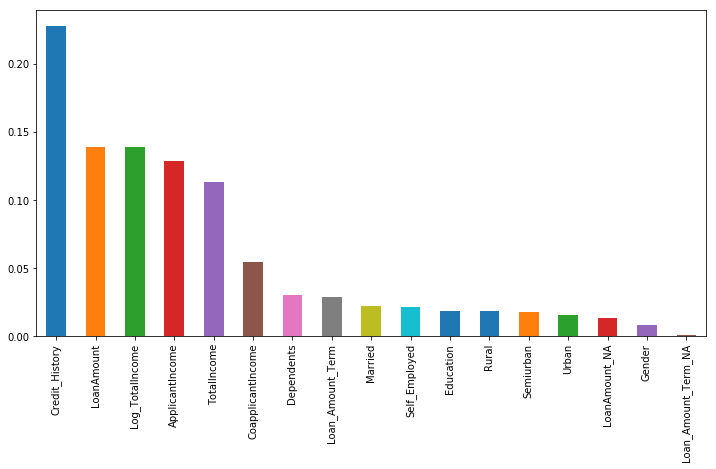

In [288]:
importance = pd.Series(rf_model.feature_importances_)
importance.index = training_vars
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

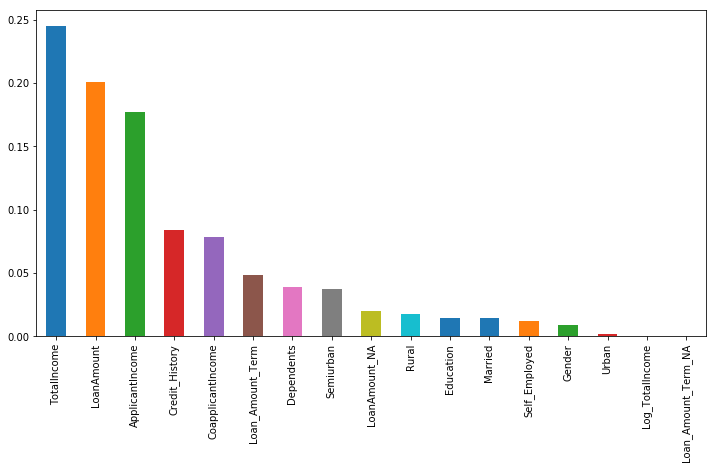

In [289]:
importance = pd.Series(xgb_model.feature_importances_)
importance.index = training_vars
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

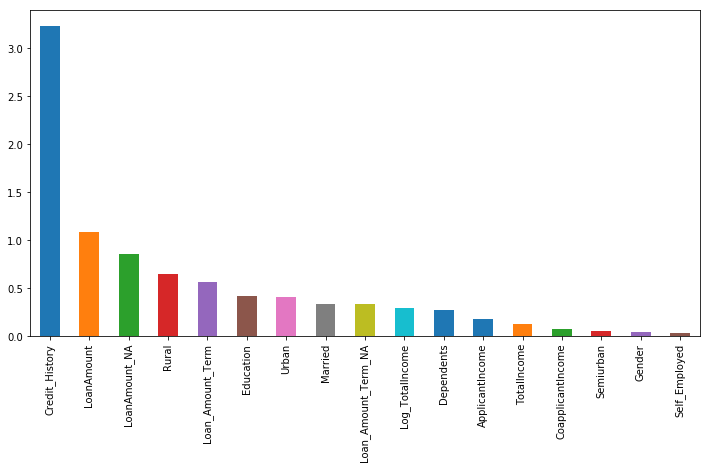

In [290]:
importance = pd.Series(np.abs(logit_model.coef_.ravel()))
importance.index = training_vars
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

In [318]:
pred = ada_model.predict(data_val[training_vars])
final = pd.DataFrame({'Loan_ID': data_val['Loan_ID'],
                     'Loan_Status': pred})
final.to_csv('loan-submission.csv',index = False)